## U-Net을 이용한 이미지 세그멘테이션
- 정보를 압축하는 인코더와 정보로부터 데이터를 복원하는 디코더로 구성
- 인코더에서 합성곱을 통해 이미지 특징 추출 후 압축
- 디코더에서 업샘플링을 통해 이미지 복원
- 복원된 특징은 원래 특징과 결합

In [64]:
import glob
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from PIL import Image
import tqdm
import torchvision.transforms as transforms
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

from model.uNet import UNet

#### 이미지 확인

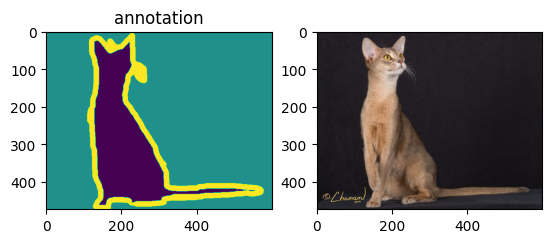

In [65]:

path_to_annotation = "./data/unet/annotations/trimaps"
path_to_image = "./data/unet/images"

annotation = Image.open(path_to_annotation + "/Abyssinian_2.png")
plt.subplot(1, 2, 1)
plt.title("annotation")
plt.imshow(annotation)

image = Image.open(path_to_image + "/Abyssinian_2.jpg")
plt.subplot(1, 2, 2)
plt.imshow(image)

plt.show()

#### utils

In [66]:
class Pets(Dataset):
  def __init__(self, path_to_image, path_to_anno, train=True, transforms=None, input_size=(128, 128)):
    self.images = sorted(glob.glob(path_to_image + "/*.jpg"))
    self.annotations = sorted(glob.glob(path_to_anno + "/*.png"))
    self.X_train = self.images[:int(0.8 * len(self.images))]
    self.X_test = self.images[int(0.8 * len(self.images)):]
    self.Y_train = self.annotations[:int(0.8*len(self.annotations))]
    self.Y_test = self.annotations[int(0.8*len(self.annotations)):]
    self.train = train
    self.transforms = transforms
    self.input_size = input_size
  def __len__(self):
    if self.train:
      return len(self.X_train)
    else:
      return len(self.X_test)
  def preprocess_mask(self, mask):
    mask = mask.resize(self.input_size)
    mask = np.array(mask).astype(np.float32)
    mask[mask != 2.0] = 1.0
    mask[mask == 2.0] = 0.0
    mask = torch.tensor(mask)
    return mask
  def __getitem__(self, i):
    if self.train:
      X_train = Image.open(self.X_train[i]).convert("RGB")
      
      X_train = self.transforms(X_train)
      Y_train = Image.open(self.Y_train[i])
      Y_train = self.preprocess_mask(Y_train)

      return X_train, Y_train
    else:
      X_test = Image.open(self.X_test[i]).convert("RGB")
      X_test = self.transforms(X_test)
      Y_test = Image.open(self.Y_test[i])
      Y_test = self.preprocess_mask(Y_test)

      return X_test, Y_test

#### 학습

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

train_set = Pets(path_to_image=path_to_image,
                 path_to_anno=path_to_annotation,
                 transforms=transform)
test_set = Pets(path_to_image=path_to_image,
                 path_to_anno=path_to_annotation,
                 transforms=transform,
                 train=False)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set)

model = UNet().to(device)

learning_rate = 0.01

optim = Adam(params=model.parameters(), lr=learning_rate)

for epoch in range(1):
  iterator = tqdm.tqdm(train_loader)

  for data, label in iterator:
    optim.zero_grad()

    preds = model(data.to(device))
    print(data.shape)
    print(label.shape)
    print(preds.shape)
    loss = nn.BCEWithLogitsLoss()(
        preds,
        label.type(torch.FloatTensor).to(device))
    loss.backward()

    optim.step()

    iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "./data/weights/UNet.pth")

  0%|          | 0/185 [00:02<?, ?it/s]

torch.Size([32, 3, 128, 128])
torch.Size([32, 128, 128])
torch.Size([32, 128, 128])


AttributeError: module 'torch.nn' has no attribute 'nn'

#### 평가

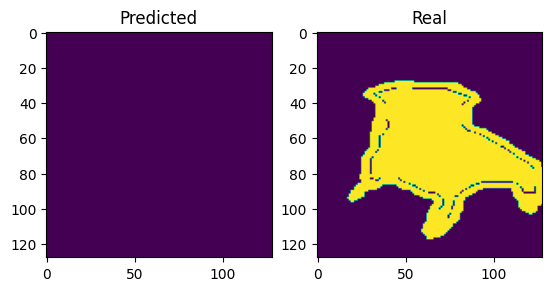

In [ ]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("./data/weights/UNet.pth", map_location="cpu"))
data, label = test_set[1]
pred = model(torch.unsqueeze(data.to(device), dim=0)) > 0.5

with torch.no_grad():
    plt.subplot(1, 2, 1)
    plt.title("Predicted")
    plt.imshow(pred)
    plt.subplot(1, 2, 2)
    plt.title("Real")
    plt.imshow(label)
    plt.show()